In [ ]:
import os
import tempfile
import numpy as np
import tensorflow as tf
from PIL import Image

In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=d65093ca13d052688f6d4a4752eb24bee118e74d52fefd1c60552f4a8e64d903
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
!git clone https://github.com/sithu31296/semantic-segmentation.git

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 792 (delta 11), reused 39 (delta 11), pack-reused 753
Receiving objects: 100% (792/792), 55.00 MiB | 31.75 MiB/s, done.
Resolving deltas: 100% (462/462), done.


In [ ]:

DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'


MODEL_TAR = 'deeplabv3_cityscapes_train_2018_02_06.tar.gz'
MODEL_URL = DOWNLOAD_URL_PREFIX + MODEL_TAR

!wget -O {MODEL_TAR} {MODEL_URL}

MODEL_FILE = !tar -zxvf {MODEL_TAR} --wildcards --no-anchored 'frozen_inference_graph.pb'
MODEL_FILE = MODEL_FILE[0].strip()
print('Frozen graph file path:', MODEL_FILE)

--2022-07-11 19:03:40--  http://download.tensorflow.org/models/deeplabv3_cityscapes_train_2018_02_06.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.161.128, 2607:f8b0:4001:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.161.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460310119 (439M) [application/x-tar]
Saving to: ‘deeplabv3_cityscapes_train_2018_02_06.tar.gz’

deeplabv3_cityscape 100%[===================>] 438.99M   124MB/s    in 3.7s    

2022-07-11 19:03:44 (117 MB/s) - ‘deeplabv3_cityscapes_train_2018_02_06.tar.gz’ saved [460310119/460310119]

Frozen graph file path: deeplabv3_cityscapes_train/frozen_inference_graph.pb


In [ ]:
cd ..

/content


In [ ]:
from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B5',
    num_classes=150
)

In [ ]:
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file = MODEL_FILE, 
    input_arrays = ['sub_7'], # For the Xception model it needs to be `sub_7`, for MobileNet it would be `sub_2`
    output_arrays = ['ResizeBilinear_2']
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]


tflite_model = converter.convert()

_, tflite_path = tempfile.mkstemp('.tflite')
tflite_model_size = open(tflite_path, 'wb').write(tflite_model)
tf_model_size = os.path.getsize(MODEL_FILE)
print('TensorFlow Model is  {} bytes'.format(tf_model_size))
print('TFLite Model is      {} bytes'.format(tflite_model_size))
print('Post training dynamic range quantization saves {} bytes'.format(tf_model_size-tflite_model_size))

TensorFlow Model is  165712950 bytes
TFLite Model is      43439824 bytes
Post training dynamic range quantization saves 122273126 bytes


In [ ]:
!ls -lh {tflite_path}

-rw------- 1 root root 42M Jul 11 19:03 /tmp/tmpsw225l7x.tflite


In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_path)

input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]
print(input_size)

(2049, 1025)


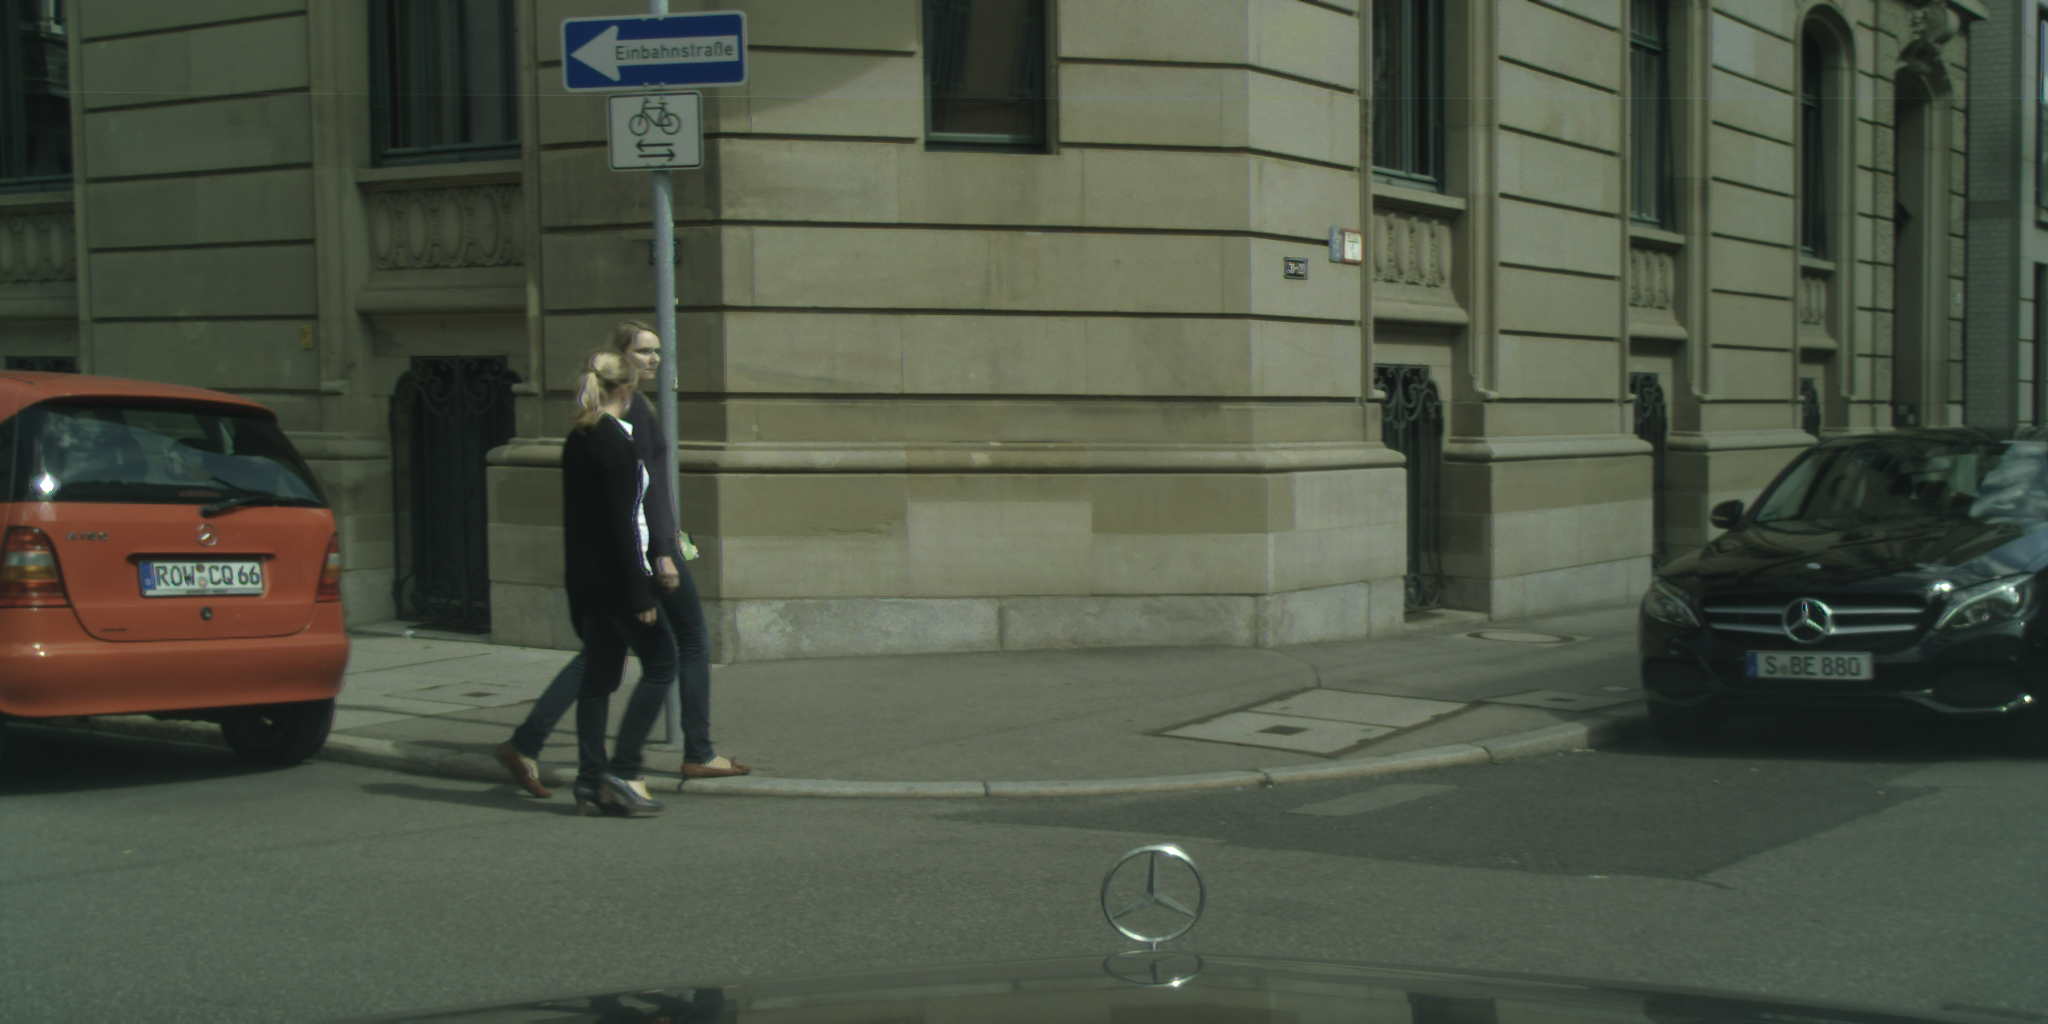

In [ ]:
from PIL import Image
image = Image.open('/content/drive/MyDrive/Datasets/stuttgart_000131_000019_leftImg8bit.png')
image

(2047, 1024) (2048, 1024)


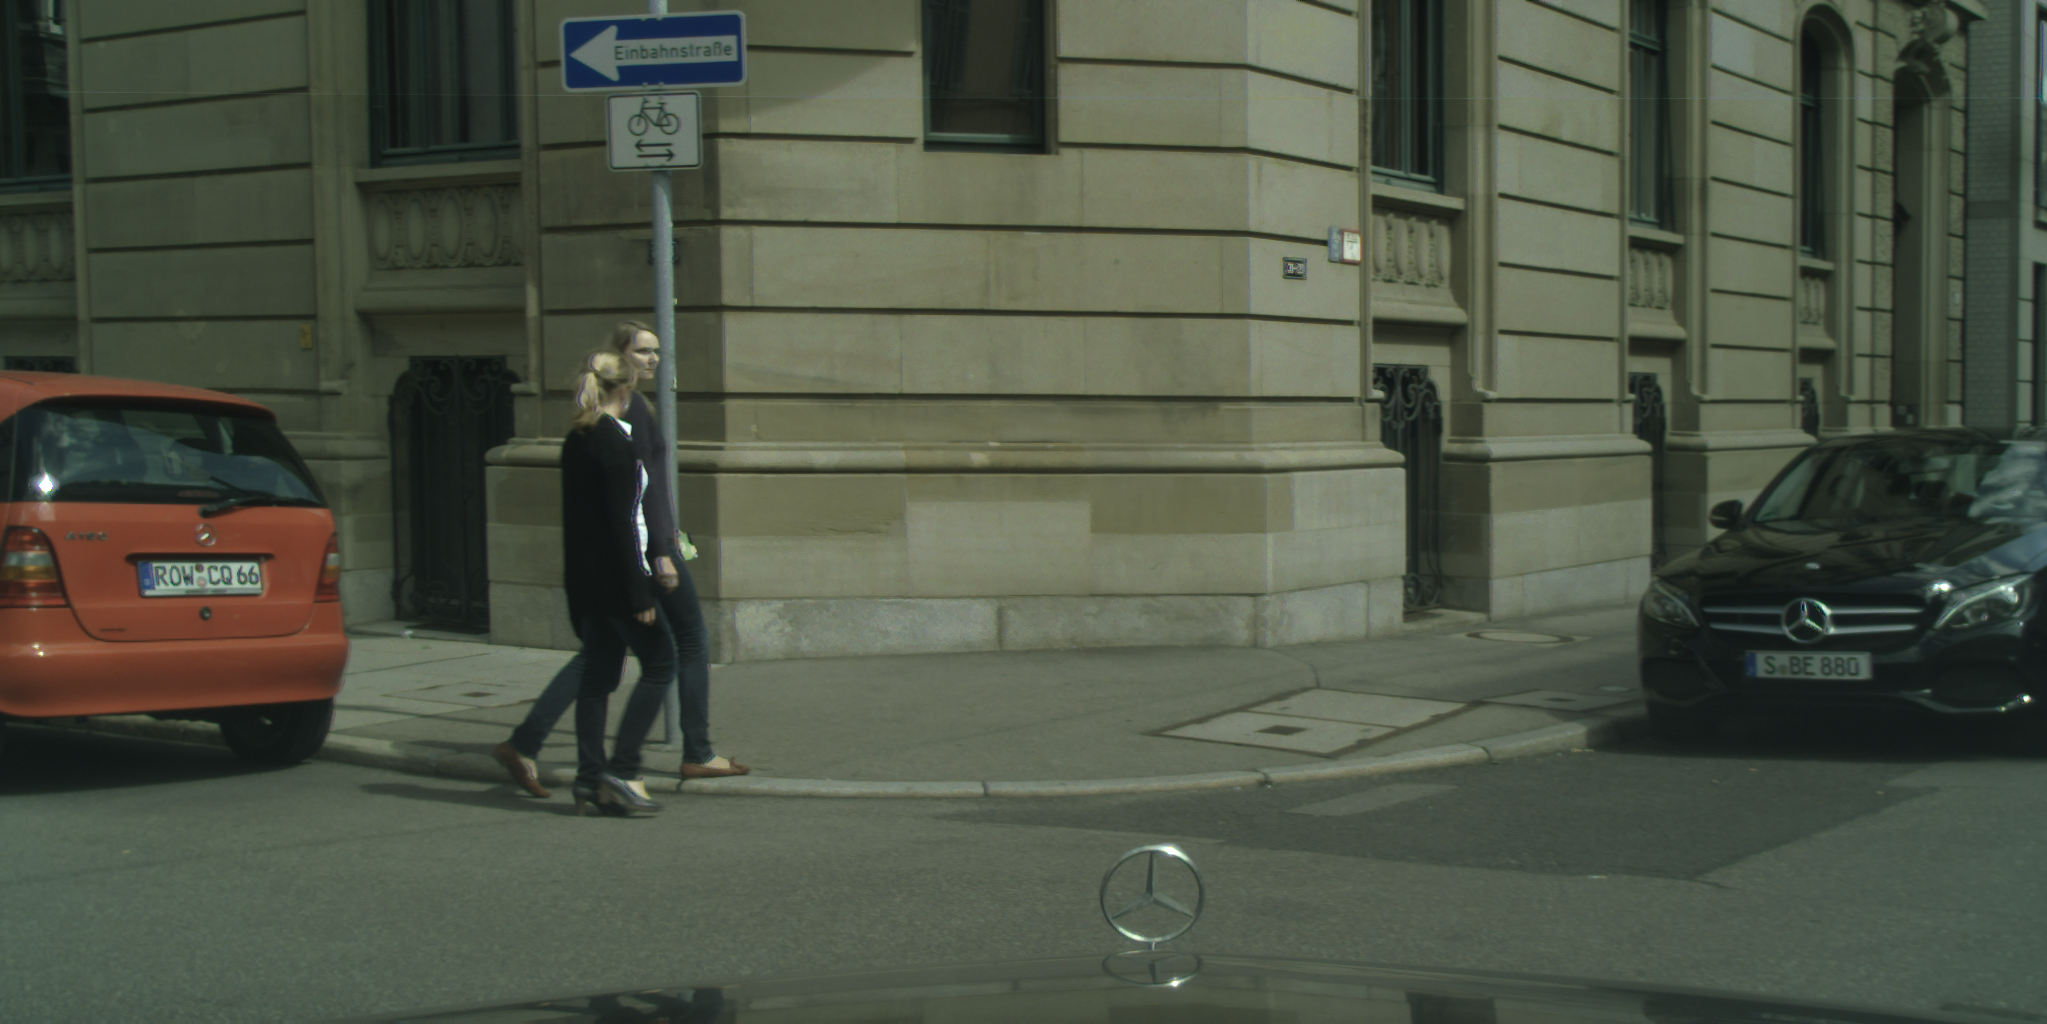

In [ ]:
from PIL import ImageOps

old_size = image.size 
desired_ratio = input_size[0] / input_size[1]
old_ratio = old_size[0] / old_size[1]

if old_ratio < desired_ratio:
    new_size = (old_size[0], int(old_size[0] / desired_ratio))
else:
    new_size = (int(old_size[1] * desired_ratio), old_size[1])

print(new_size, old_size)

delta_w = new_size[0] - old_size[0]
delta_h = new_size[1] - old_size[1]
padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
cropped_image = ImageOps.expand(image, padding)
cropped_image

In [ ]:
resized_image = cropped_image.convert('RGB').resize(input_size, Image.BILINEAR)

image_for_prediction = np.asarray(resized_image).astype(np.float32)
image_for_prediction = np.expand_dims(image_for_prediction, 0)
image_for_prediction = image_for_prediction / 127.5 - 1

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_path)

interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], image_for_prediction)
interpreter.invoke()

raw_prediction = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

width, height = cropped_image.size
seg_map = tf.argmax(tf.image.resize(raw_prediction, (height, width)), axis=3)
seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)

In [ ]:
from matplotlib import gridspec
from matplotlib import pyplot as plt

def create_cityscapes_label_colormap():
  colormap = np.zeros((256, 3), dtype=np.uint8)
  colormap[0] = [128, 64, 128]
  colormap[1] = [244, 35, 232]
  colormap[2] = [70, 70, 70]
  colormap[3] = [102, 102, 156]
  colormap[4] = [190, 153, 153]
  colormap[5] = [153, 153, 153]
  colormap[6] = [250, 170, 30]
  colormap[7] = [220, 220, 0]
  colormap[8] = [107, 142, 35]
  colormap[9] = [152, 251, 152]
  colormap[10] = [70, 130, 180]
  colormap[11] = [220, 20, 60]
  colormap[12] = [255, 0, 0]
  colormap[13] = [0, 0, 142]
  colormap[14] = [0, 0, 70]
  colormap[15] = [0, 60, 100]
  colormap[16] = [0, 80, 100]
  colormap[17] = [0, 0, 230]
  colormap[18] = [119, 11, 32]
  return colormap


def label_to_color_image(label):
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_cityscapes_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

'''
def vis_segmentation(image, seg_map):
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()
'''

LABEL_NAMES = np.asarray([
      'road',
      'sidewalk',
      'building',
      'wall',
      'fence',
      'pole',
      'traffic light',
      'traffic sign',
      'vegetation',
      'terrain',
      'sky',
      'person',
      'rider',
      'car',
      'truck',
      'bus',
      'train',
      'motorcycle',
      'bicycle',
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

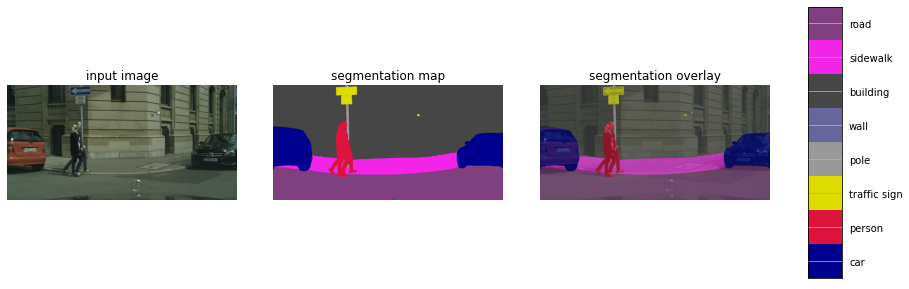

In [ ]:
image=cropped_image
plt.figure(figsize=(15, 5))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

plt.subplot(grid_spec[0])
plt.imshow(image)
plt.axis('off')
plt.title('input image')

plt.subplot(grid_spec[1])
seg_image = label_to_color_image(seg_map).astype(np.uint8)
plt.imshow(seg_image)
plt.axis('off')
plt.title('segmentation map')

plt.subplot(grid_spec[2])
plt.imshow(image)
plt.imshow(seg_image, alpha=0.6)
plt.axis('off')
plt.title('segmentation overlay')

unique_labels = np.unique(seg_map)
ax = plt.subplot(grid_spec[3])
plt.imshow(
    FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
ax.yaxis.tick_right()
plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
plt.xticks([], [])
ax.tick_params(width=0.0)
plt.grid('off')
plt.show()

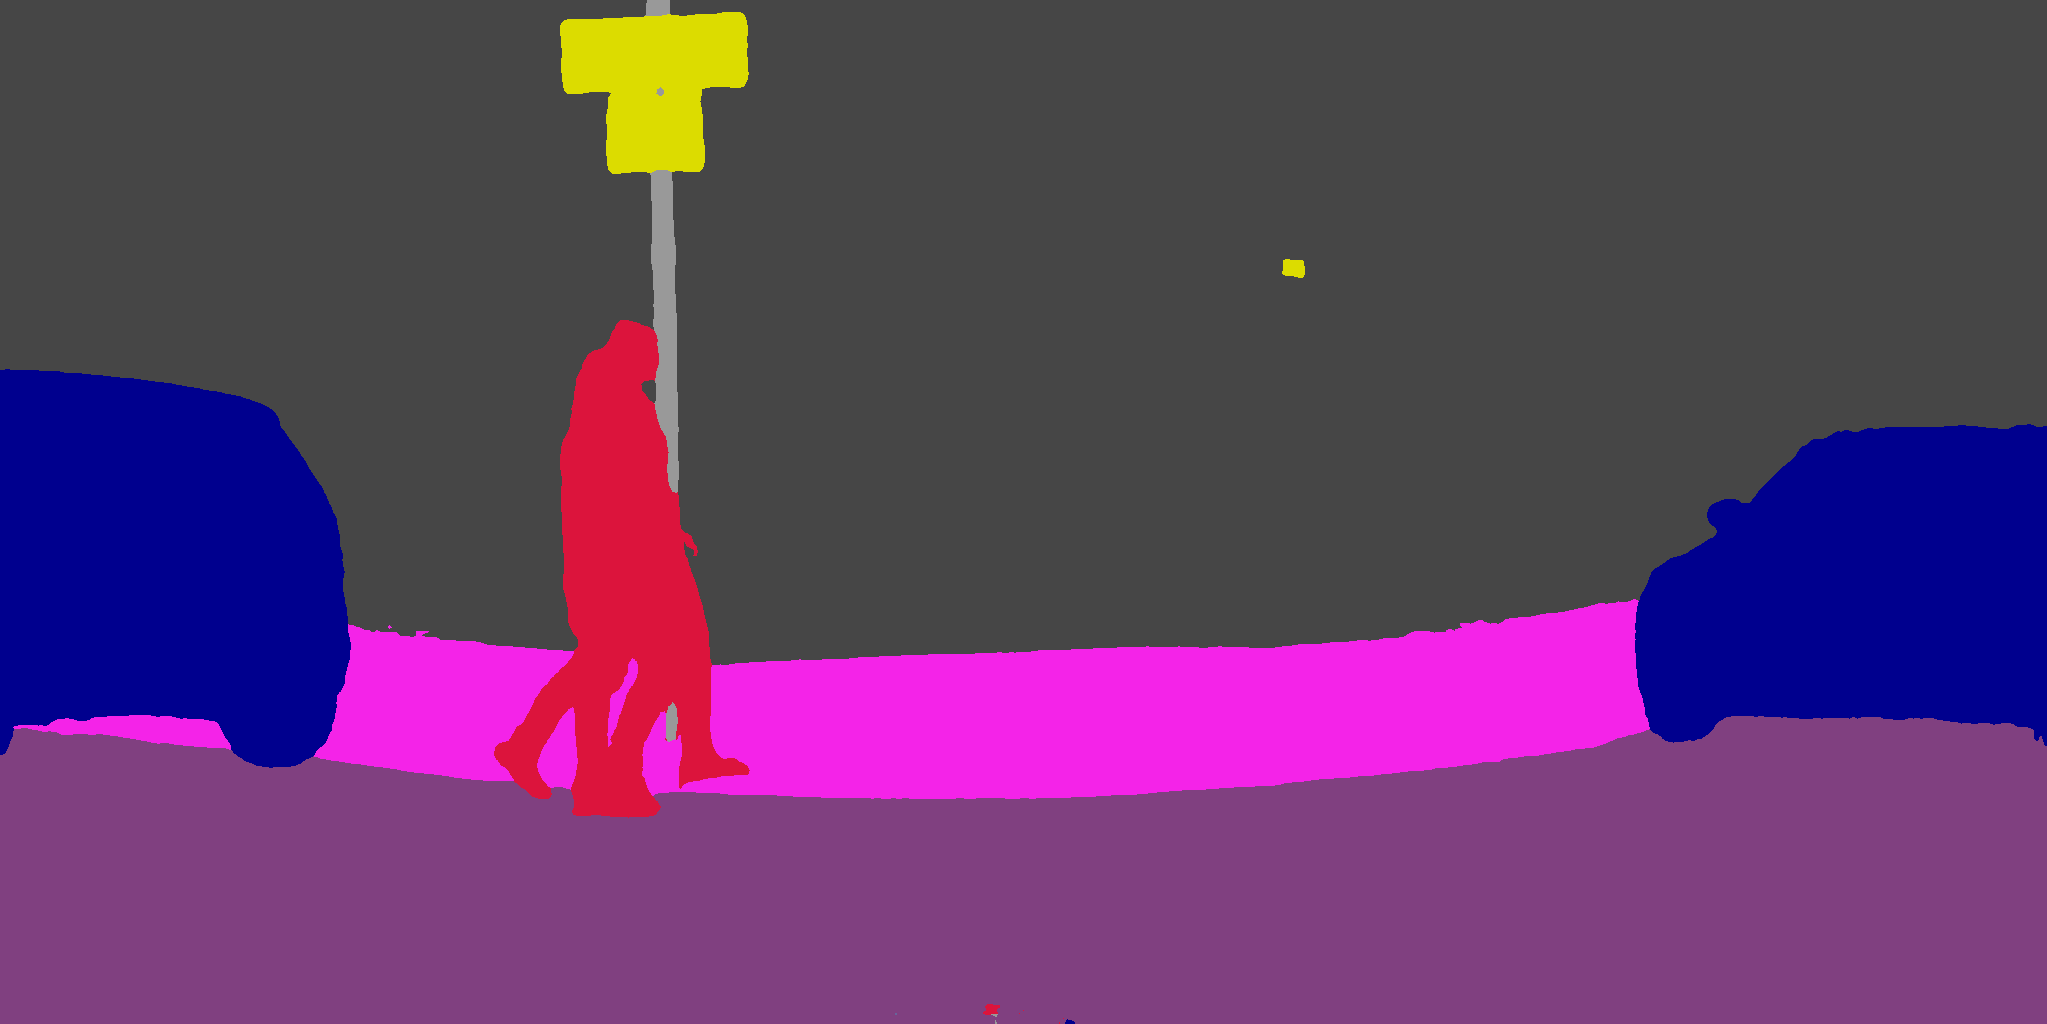

In [ ]:
segmented_image=Image.fromarray(seg_image, 'RGB')
segmented_image

In [ ]:
segmented_image.save("/content/drive/MyDrive/Datasets/pred.jpg")

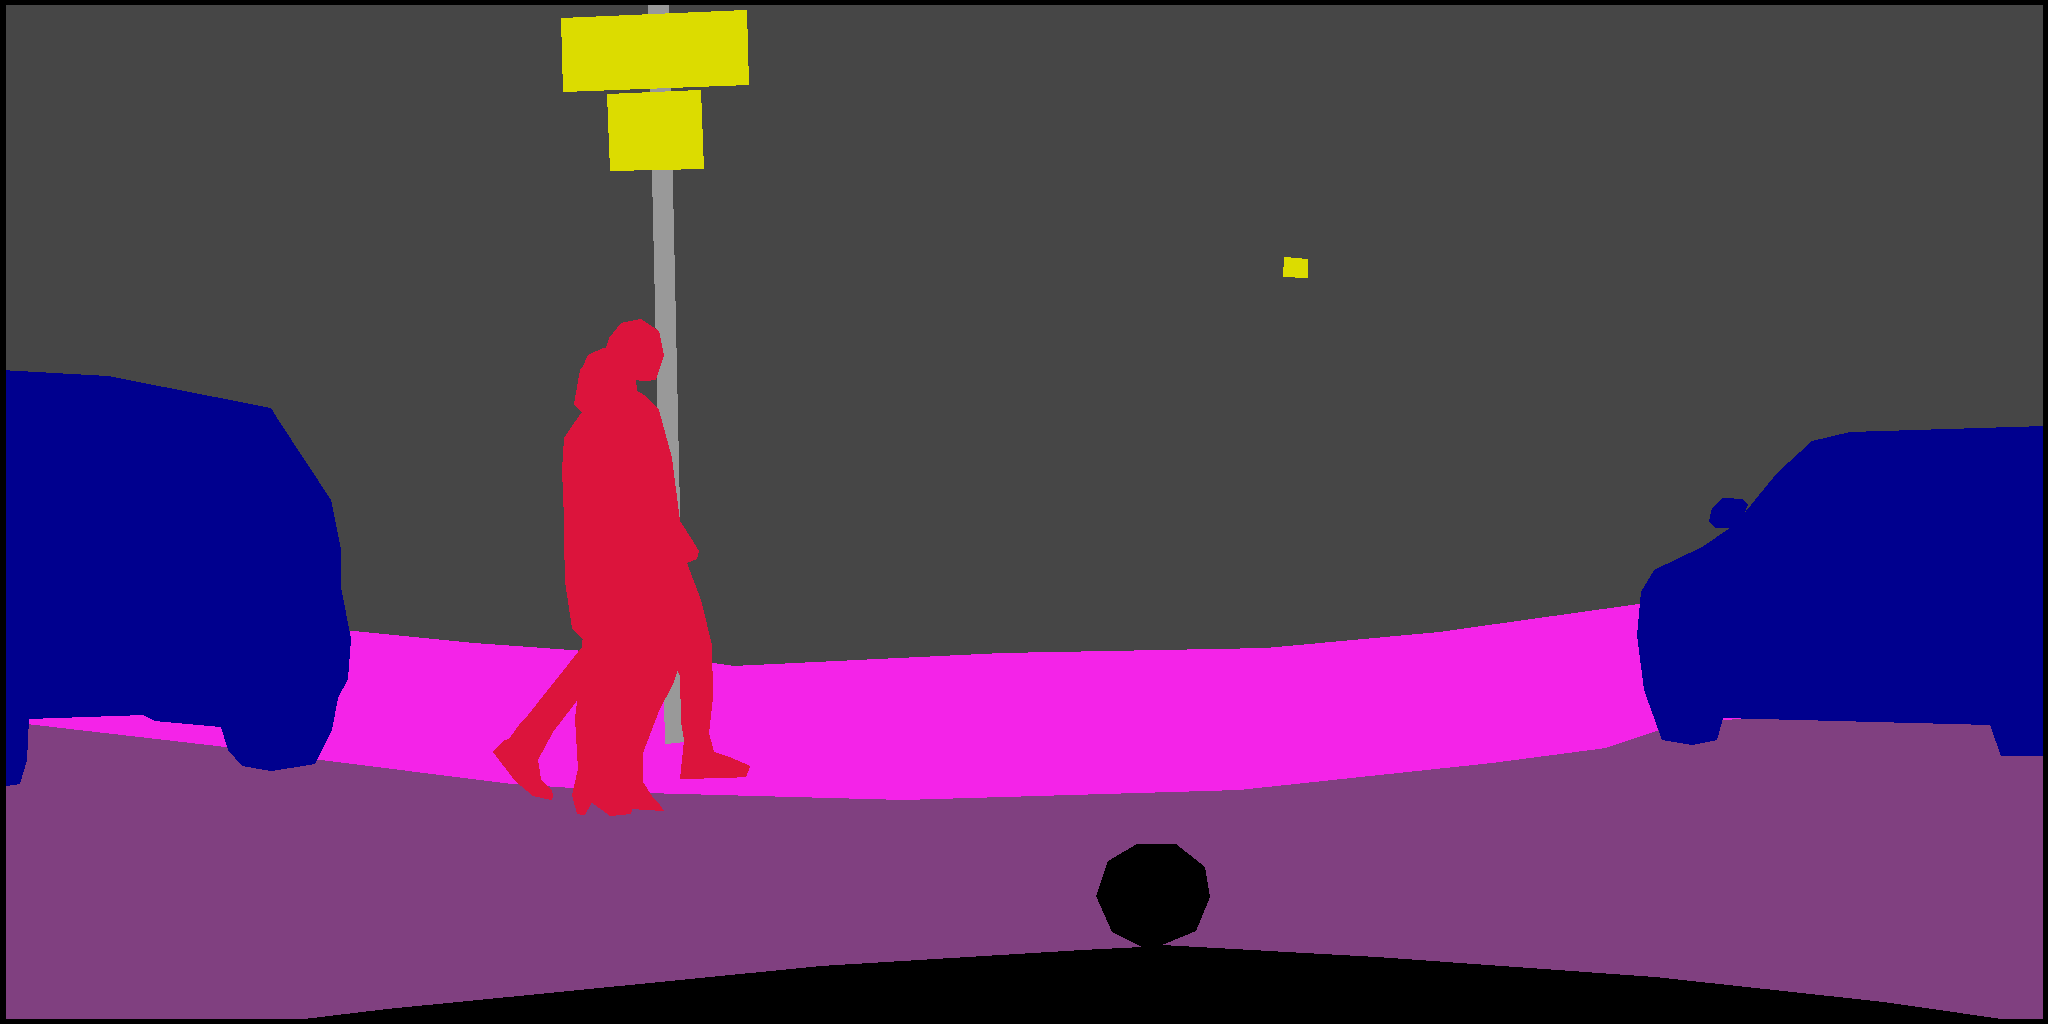

In [ ]:
gt=Image.open('/content/drive/MyDrive/Datasets/stuttgart_000131_000019_gtFine_color.png')
gt

In [ ]:
import cv2
from sklearn import metrics

In [ ]:
truth=cv2.imread("/content/drive/MyDrive/Datasets/stuttgart_000131_000019_gtFine_color.png", 0).reshape(-1)
pred=cv2.imread("/content/drive/MyDrive/Datasets/pred.jpg", 0).reshape(-1)

In [ ]:
truth.shape

(2097152,)

In [ ]:
pred.shape

(2096128,)

In [ ]:
type(truth)

numpy.ndarray

In [ ]:
type(pred)

numpy.ndarray

In [ ]:
truth = np.resize(truth, (2096128,))

In [ ]:
A=truth
B=pred
print(A.shape)
print(B.shape)

(2096128,)
(2096128,)


In [ ]:
len1=len(truth)
len2=len(pred)
if len1<len2:
  truth=np.append(truth, np.zeros((len2-len1)),axis=0)
elif len2<len1:
  pred=np.append(pred, np.zeros((len1-len2)),axis=0)
print(truth.shape)
print(pred.shape)
if (truth.shape != pred.shape):
  print("we have an error")
else:
  print("we r good")

(2096128,)
(2096128,)
we r good


In [ ]:
if A.shape[0] < B.shape[0]:
    A = np.vstack((A, np.zeros((B.shape[0] - A.shape[0]))))
elif A.shape[0] > B.shape[0]:
    B = np.vstack((B, np.zeros((A.shape[0] - B.shape[0], A.shape[0])))) 

print(A.shape)
print(B.shape)

(2096128,)
(2096128,)


In [ ]:
print("Accuracy", metrics.accuracy_score(truth, pred))

Accuracy 0.872808607107963


In [ ]:
from keras.metrics import MeanIoU

In [ ]:
truth

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
pred

array([70, 70, 70, ..., 90, 90, 90], dtype=uint8)

In [ ]:
mxresult=np.amax(pred)
mxresult

233

In [ ]:
mxresult=np.amax(truth)
mxresult

194

In [ ]:
pred1=pred/233

In [ ]:
truth1=truth/194

In [ ]:
num_classes=19
IOU_keras=MeanIoU(num_classes=num_classes)
IOU_keras.update_state(truth1, pred1)
print("MIoU: ",IOU_keras.result().numpy())

MIoU:  0.8248221
